In [1]:
!pip install wfdb --quiet
!pip install keras-tuner --quiet
!pip install resnet1d --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

In [4]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [5]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A','/']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [6]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [7]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def display_ecg_with_masks(signal, mask, fs=250):
    
    time = np.arange(len(signal)) / fs 
    if mask.ndim == 1:
        num_classes = 4  
        mask = np.eye(num_classes)[mask]  

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, color='black', label='ECG Signal')

    plt.fill_between(time, -1, 1, where=mask[:, 0] > 0.5, color='gray', alpha=0.3, label='background')
    plt.fill_between(time, -1, 1, where=mask[:, 1] > 0.5, color='blue', alpha=0.3, label='P wave')
    plt.fill_between(time, -1, 1, where=mask[:, 2] > 0.5, color='red', alpha=0.3, label='QRS Complex')
    plt.fill_between(time, -1, 1, where=mask[:, 3] > 0.5, color='green', alpha=0.3, label='T wave')

    plt.title("ECG Signal with Annotated Wave Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np
import wfdb

def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs

    annotations = wfdb.rdann(record_path, 'pu0' if Type == 'QTDB' else 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    window_size = 240
    stride = window_size // 4  
    
    remainder = (len(signal) - window_size) % stride
    padding = (stride - remainder) if remainder != 0 else 0
    if padding > 0:
        signal = np.pad(signal, (0, padding), mode='constant', constant_values=signal[-1])

    
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    mask = create_multi_class_mask(len(signal), wave_regions)

    indices = np.where(mask[:, 0] != 1)[0] 
    first_non_zero_row = indices[0] if len(indices) > 0 else None
    last_non_zero_row = indices[-1] if len(indices) > 0 else None
    

    padding = 5
    first_non_zero_row-=padding
    if (first_non_zero_row<0):first_non_zero_row=0
    last_non_zero_row+=padding
    if (last_non_zero_row>len(signal)-1):last_non_zero_row=len(signal)-1
    mask=mask[first_non_zero_row:last_non_zero_row]
    signal=signal[first_non_zero_row:last_non_zero_row]
    
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)


    if len(segments) * stride + window_size - stride < len(signal):
        pad_needed = len(signal) - (len(segments) * stride + window_size - stride)
        signal = np.pad(signal, (0, pad_needed), mode='constant', constant_values=signal[-1])
        mask = np.pad(mask, (0, pad_needed), mode='constant', constant_values=0)  


    segments = np.expand_dims(segments, axis=1) 


    masks = np.argmax(masks, axis=-1)            

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  
path='/kaggle/input/qtdb-ludb/'
qtdb_path = path + "physionet.org/files/qtdb/1.0.0/"
ludb_path = path + "physionet.org/files/ludb/1.0.1/data/"


qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


Processing QTDB Records: 100%|██████████| 105/105 [00:17<00:00,  6.11it/s]


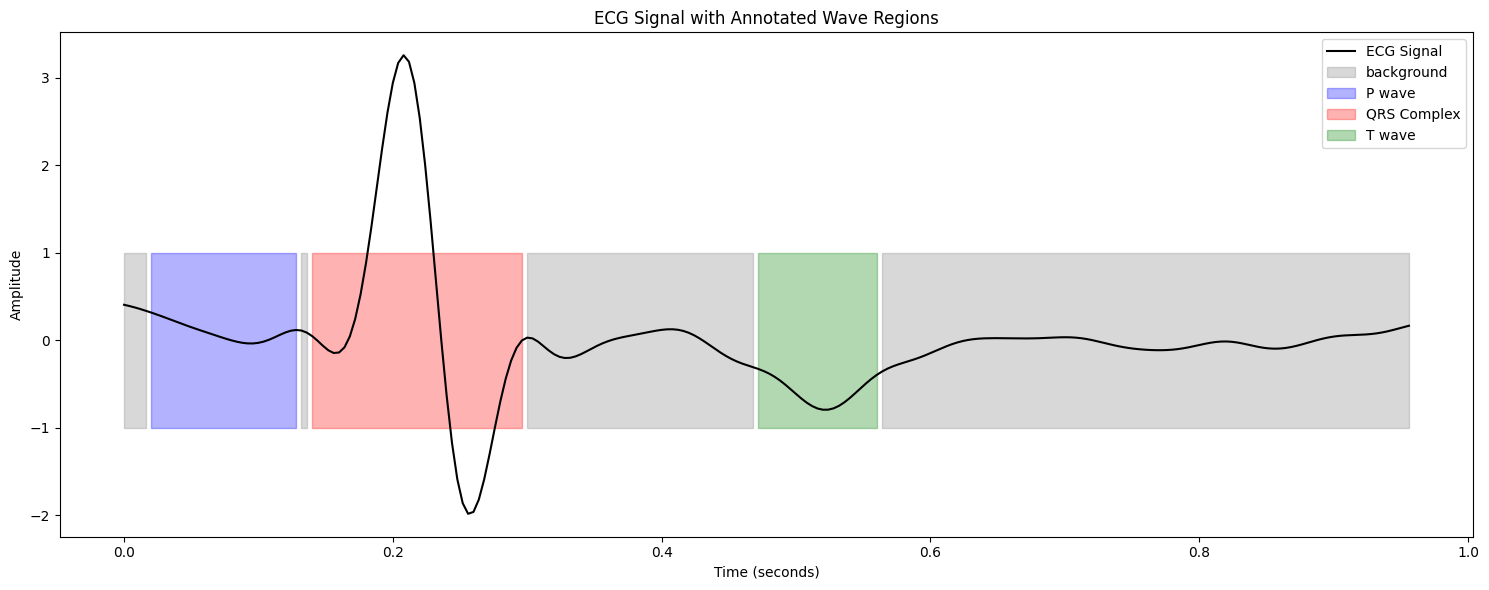

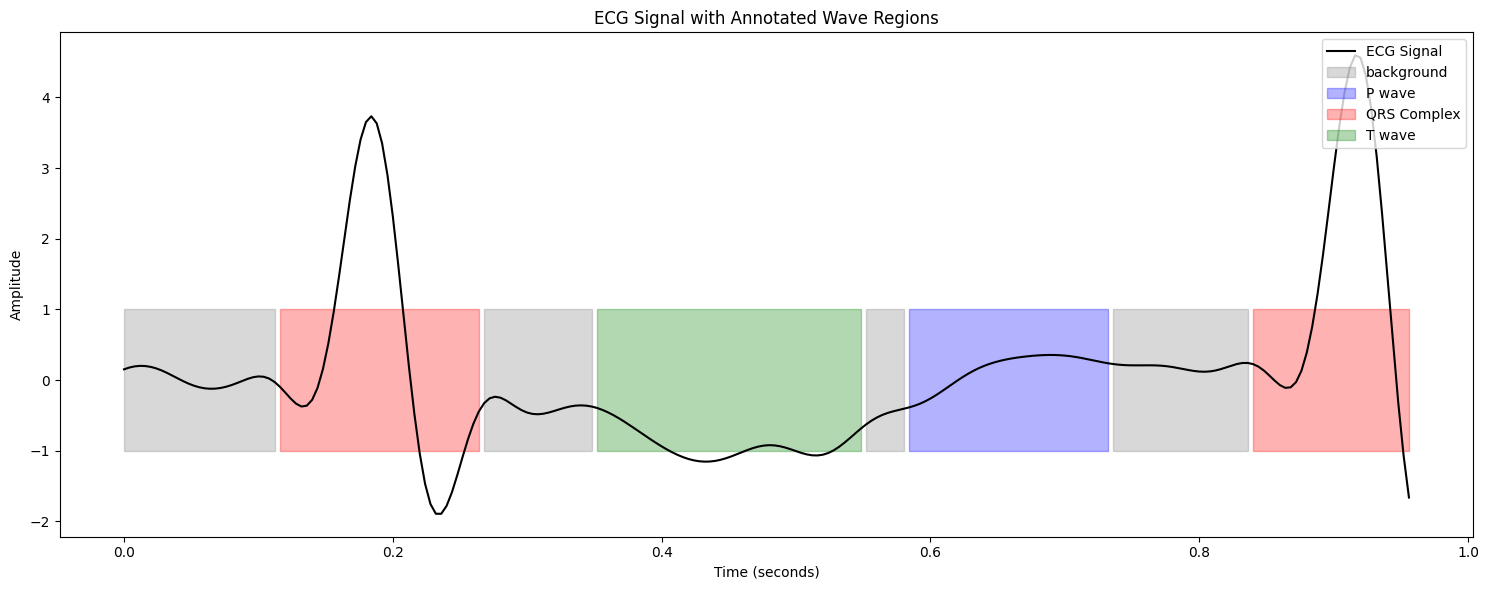

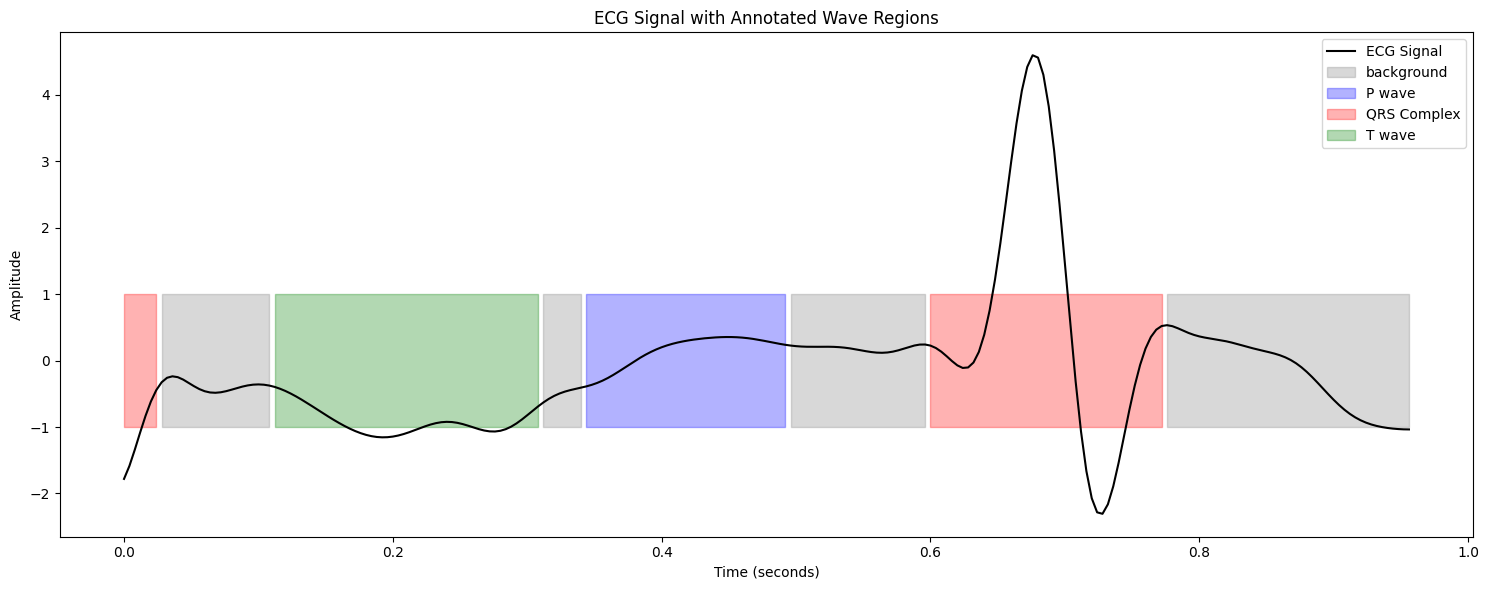

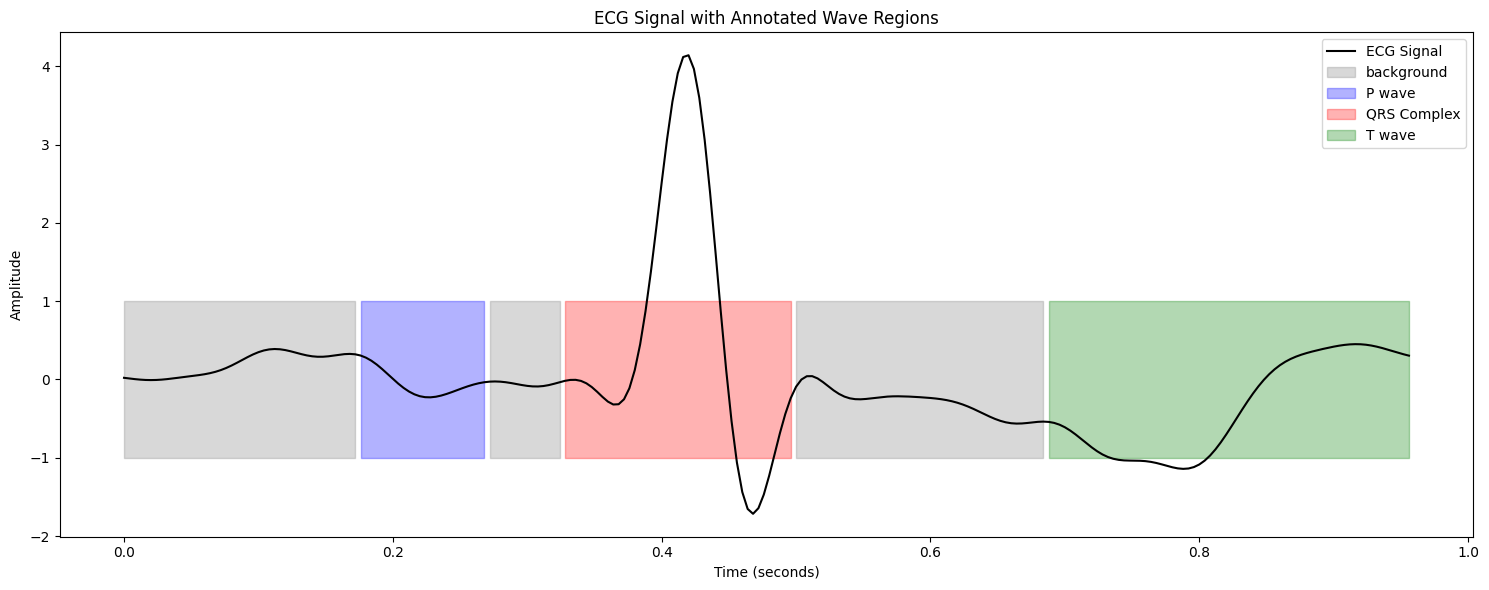

In [11]:
from tqdm import tqdm
qt_segments_list, qt_masks_list = [], []

for record_path in tqdm(qt_records, desc="Processing QTDB Records"):
#if(True):
#    record_path = "sel232"
    try:

        #print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)

    except:
        print(f"Skipping {record_path} due to error.")

display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])



Processing LUDB Records: 100%|██████████| 200/200 [00:04<00:00, 49.59it/s]


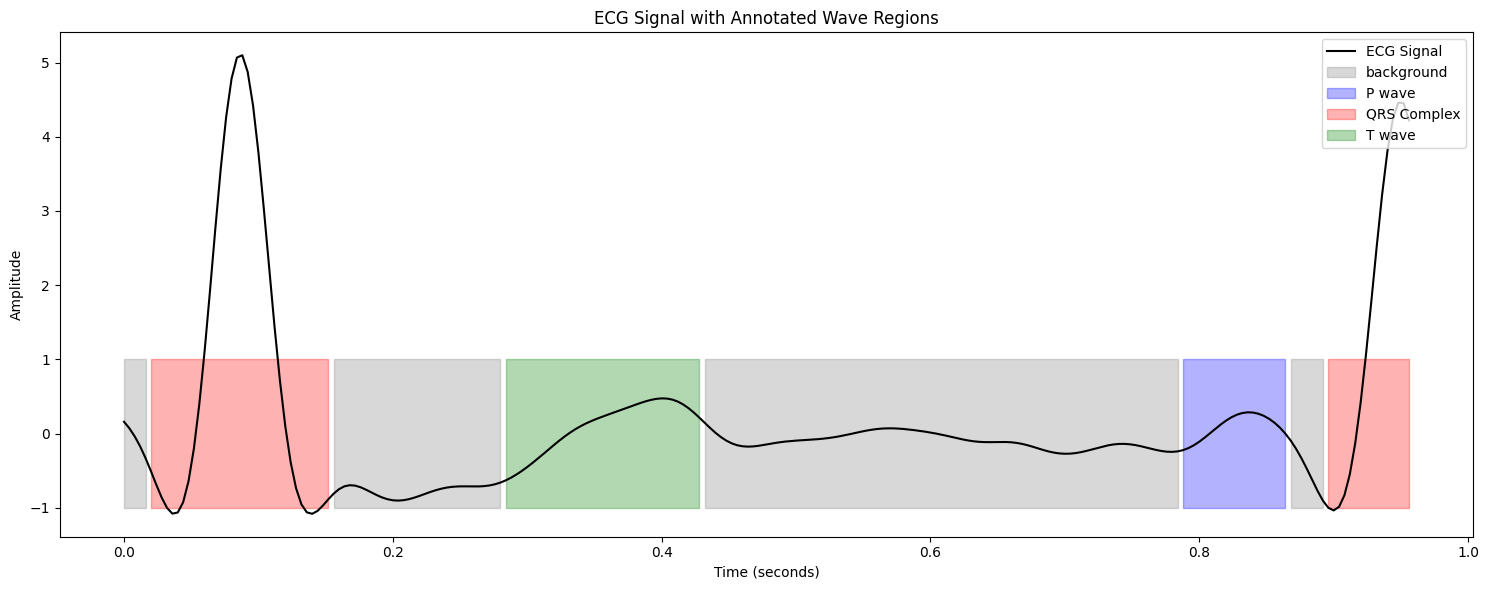

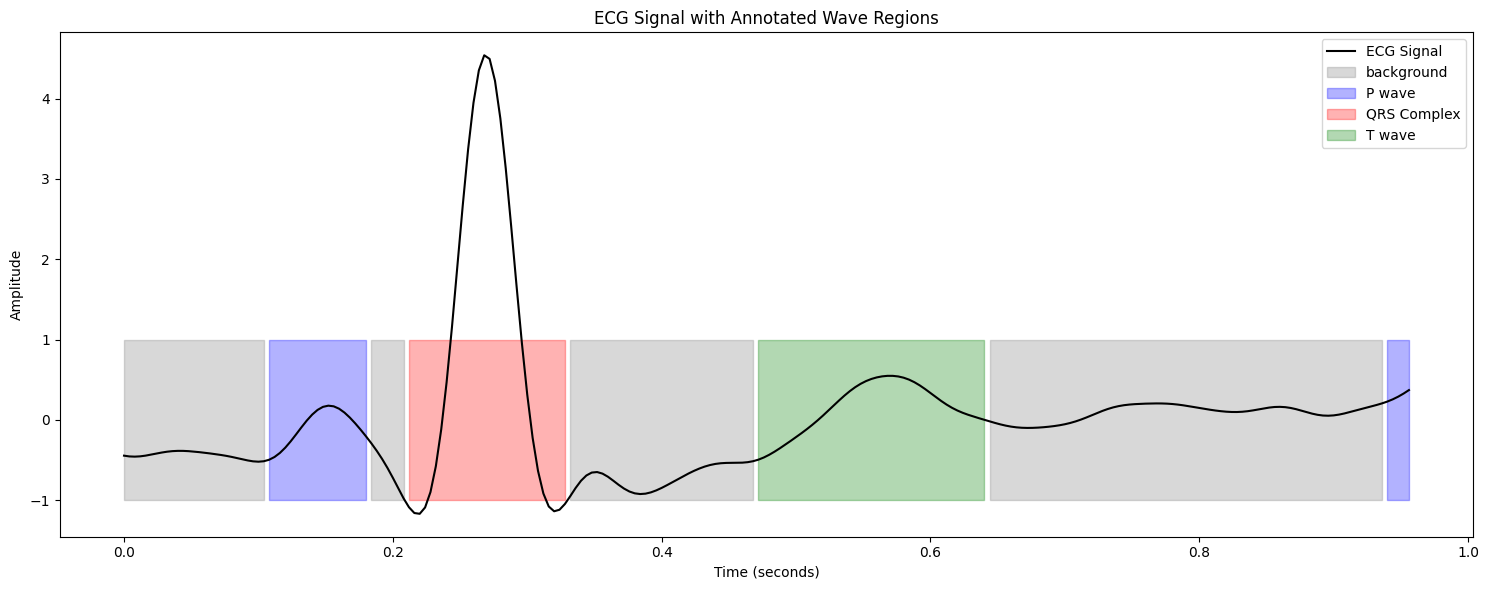

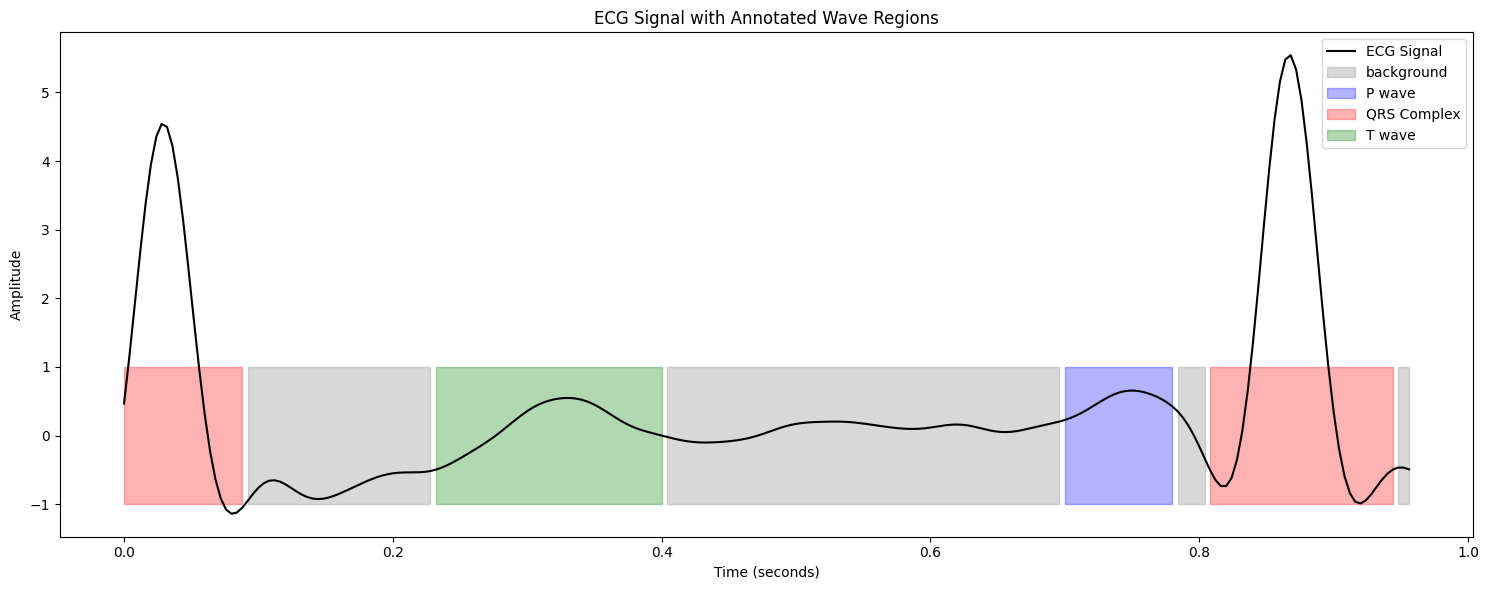

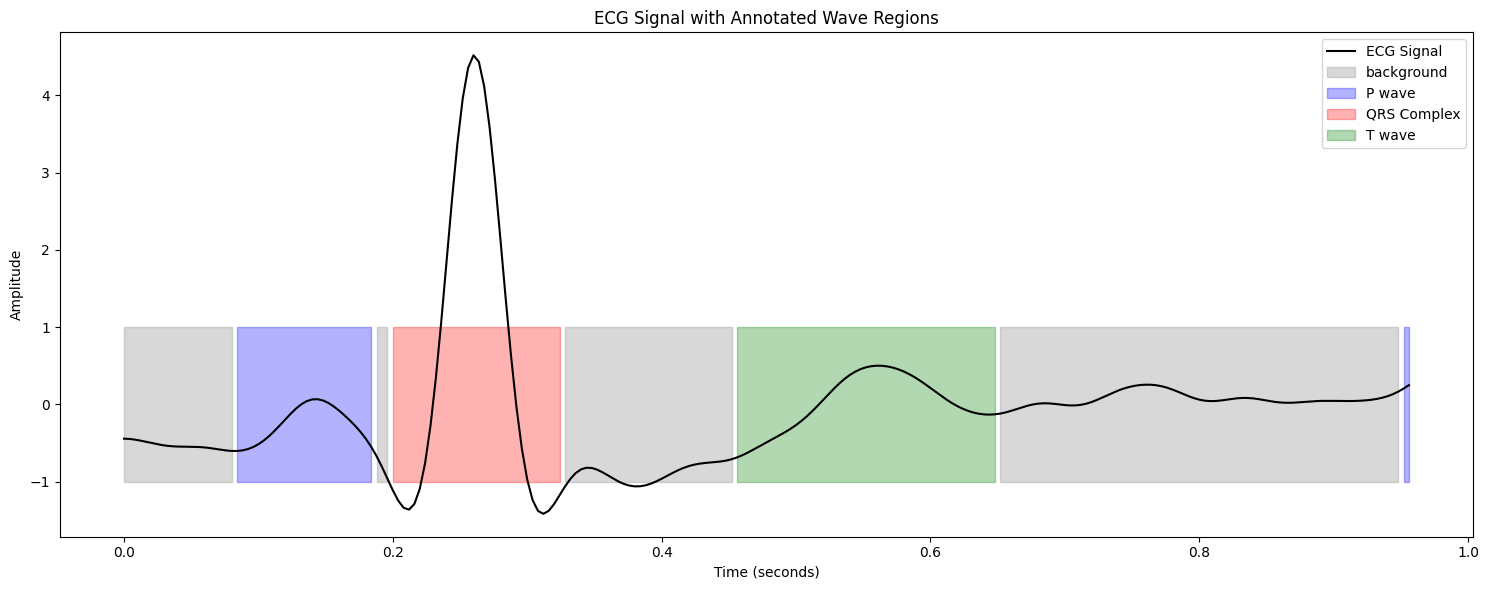

In [12]:


lu_segments_list, lu_masks_list = [], []

for record_path in tqdm(lu_records, desc="Processing LUDB Records"):
    try:

        segments, masks = process_record(
            ludb_path + record_path,
            Type='LUDB',
            extra_ms={'p':0, 'N':20, 't':0},
            target_fs=250
        )
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)

    except Exception as e:
        print(f"Skipping {record_path} due to error: {e}")




display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:

X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [15]:

y = np.concatenate([qt_masks, lu_masks])
print(y)

[[0 0 0 ... 0 0 0]
 [2 2 2 ... 2 2 2]
 [3 3 3 ... 3 3 3]
 ...
 [0 0 0 ... 3 3 3]
 [3 3 3 ... 0 0 0]
 [0 0 0 ... 0 1 1]]


In [16]:
import numpy as np

flat_y = y.flatten()

# Count occurrences of each class
unique_classes, class_counts = np.unique(flat_y, return_counts=True)

# Compute total number of labels
total_labels = np.sum(class_counts)
from re import S
import os
# Compute class weights
class_weights = class_counts / total_labels

# Display results
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class Counts:", dict(zip(unique_classes, class_counts)))
print("Class Weights (Relative Frequency):", class_weight_dict)

# Get weight of class 0
weight_0 = class_weight_dict.get(0, 0)
print(f"Weight of Class 0: {weight_0:.4f}")


Class Counts: {0: 45861096, 1: 9742522, 2: 17298084, 3: 22661258}
Class Weights (Relative Frequency): {0: 0.47990451530593026, 1: 0.10194872574060075, 2: 0.1810124341062688, 3: 0.2371343248472002}
Weight of Class 0: 0.4799


In [17]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, 
                                    MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed,
                                    Bidirectional, GlobalAveragePooling1D, concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np


2025-06-05 08:02:51.669632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749110571.892008      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749110571.954391      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, 
    Dropout, BatchNormalization, TimeDistributed,
    Flatten,Permute
)
from tensorflow.keras.optimizers import Adam


def build_ecg_segmentation_model(input_length=240, num_classes=4):
    
    inputs = Input(shape=(1, input_length))  
    
    # Permute dimensions to get (timesteps, channels)
    x = Permute((2, 1))(inputs)  
    
    x = Conv1D(64, kernel_size=15, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = Conv1D(128, kernel_size=15, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)



    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:

model = build_ecg_segmentation_model(input_length=240, num_classes=4)
model.summary()


I0000 00:00:1749110585.056831      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749110585.057432      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 240)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ (None, 240, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 240, 64)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 240, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 240, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 240, 128)            │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 240, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 240, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 240, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 240, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 240, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 240, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 240, 4)              │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,052 (1.17 MB)

 Trainable params: 305,668 (1.17 MB)

 Non-trainable params: 384 (1.50 KB)

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/30


I0000 00:00:1749110593.971039      88 cuda_dnn.cc:529] Loaded cuDNN version 90300


9955/9955 ━━━━━━━━━━━━━━━━━━━━ 223s 22ms/step - accuracy: 0.8841 - loss: 0.3101 - val_accuracy: 0.9201 - val_loss: 0.2111
Epoch 2/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 214s 22ms/step - accuracy: 0.9208 - loss: 0.2102 - val_accuracy: 0.9286 - val_loss: 0.1873
Epoch 3/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 215s 22ms/step - accuracy: 0.9266 - loss: 0.1937 - val_accuracy: 0.9317 - val_loss: 0.1783
Epoch 4/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 215s 22ms/step - accuracy: 0.9301 - loss: 0.1840 - val_accuracy: 0.9331 - val_loss: 0.1737
Epoch 5/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 215s 22ms/step - accuracy: 0.9318 - loss: 0.1786 - val_accuracy: 0.9351 - val_loss: 0.1687
Epoch 6/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 215s 22ms/step - accuracy: 0.9336 - loss: 0.1736 - val_accuracy: 0.9346 - val_loss: 0.1691
Epoch 7/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 214s 22ms/step - accuracy: 0.9346 - loss: 0.1705 - val_accuracy: 0.9368 - val_loss: 0.1642
Epoch 8/30
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 215s 22ms/step - accuracy: 0.9356 - lo

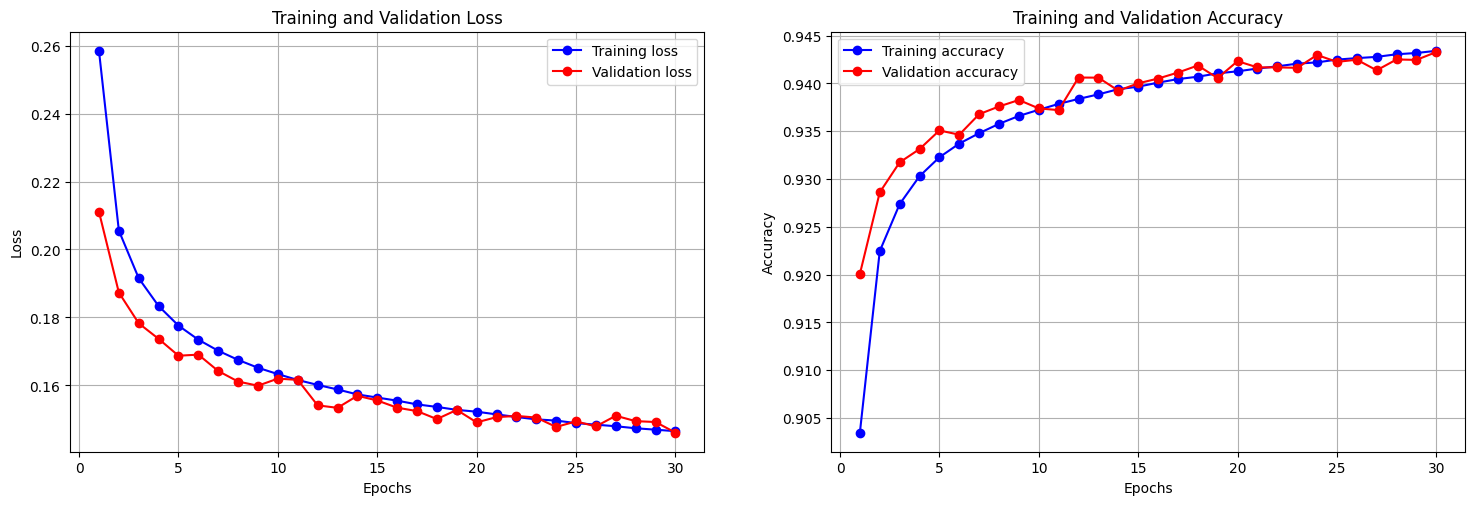

In [23]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 12))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accs, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


In [24]:

test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc} , Test Loss: {test_loss}")

# Predict on the test set
y_pred = model.predict(X_test)

623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9439 - loss: 0.1445
Test Accuracy: 0.9439723491668701 , Test Loss: 0.14447298645973206
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [25]:
y_pred1 = (y_pred > 0.5).astype(int)  
num_classes = 4
y_test1 = np.eye(num_classes)[y_test]

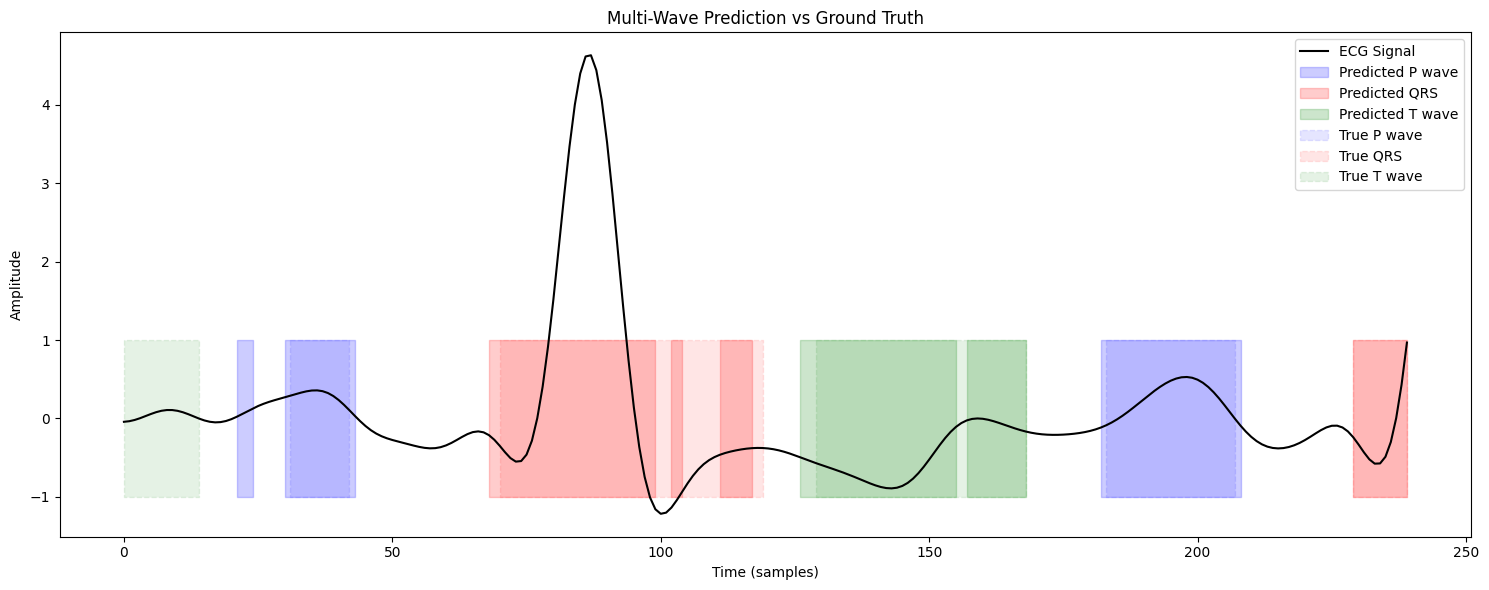

In [26]:
import matplotlib.pyplot as plt
import numpy as np

index = 0  # Sample to visualize
signal = X_test[index].flatten()
pred_mask = y_pred1[index]

true_mask = y_test1[index].astype(int)
time = np.arange(len(signal))

plt.figure(figsize=(15, 6))
plt.plot(time, signal, color='black', label='ECG Signal')

# Plot predicted masks
plt.fill_between(time, -1, 1, where=pred_mask[:, 1] > 0.5, color='blue', alpha=0.2, label='Predicted P wave')
plt.fill_between(time, -1, 1, where=pred_mask[:, 2] > 0.5, color='red', alpha=0.2, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=pred_mask[:, 3] > 0.5, color='green', alpha=0.2, label='Predicted T wave')

# Plot ground truth masks
plt.fill_between(time, -1, 1, where=true_mask[:, 1] > 0.5, color='blue', alpha=0.1, label='True P wave', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 2] > 0.5, color='red', alpha=0.1, label='True QRS', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 3] > 0.5, color='green', alpha=0.1, label='True T wave', linestyle='dashed')

plt.title('Multi-Wave Prediction vs Ground Truth')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [27]:
model.save('CNN-LSTM.keras') 


# testing model on ecg signal

In [28]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    
    signal = signal[:len(signal) - (len(signal) % window_size)]  
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    
    target_fs = 250
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
    
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    
    segments = []
    predictions = []
    
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)
        
        output = model.predict(window, verbose=0)  # (1, 240, 4)
        pred = np.argmax(output, axis=-1)[0]  # (240,)
        predictions.append(pred)
    
    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [29]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


6000
{'P': [(960, 970), (2382, 2389), (2392, 2393), (2640, 2649), (4014, 4036), (5210, 5226), (5784, 5785), (5789, 5790), (5874, 5875), (5881, 5891)], 'QRS': [(0, 53), (196, 263), (403, 467), (602, 665), (801, 863), (994, 1030), (1032, 1033), (1192, 1253), (1409, 1472), (1615, 1677), (1818, 1882), (2019, 2085), (2221, 2286), (2415, 2452), (2455, 2455), (2614, 2639), (2669, 2676), (2825, 2890), (3033, 3103), (3243, 3307), (3446, 3507), (3644, 3708), (3841, 3874), (4039, 4086), (4239, 4306), (4456, 4519), (4658, 4727), (4867, 4932), (5063, 5131), (5265, 5296), (5462, 5510), (5660, 5719), (5869, 5870), (5877, 5877), (5892, 5943)], 'T': [(57, 135), (266, 347), (492, 536), (676, 685), (697, 739), (880, 954), (1037, 1099), (1107, 1130), (1254, 1343), (1473, 1553), (1694, 1695), (1700, 1702), (1705, 1763), (1883, 1884), (1896, 1919), (1928, 1977), (2090, 2159), (2293, 2295), (2299, 2377), (2461, 2524), (2526, 2529), (2692, 2756), (2894, 2970), (3105, 3107), (3112, 3119), (3128, 3132), (3134, 

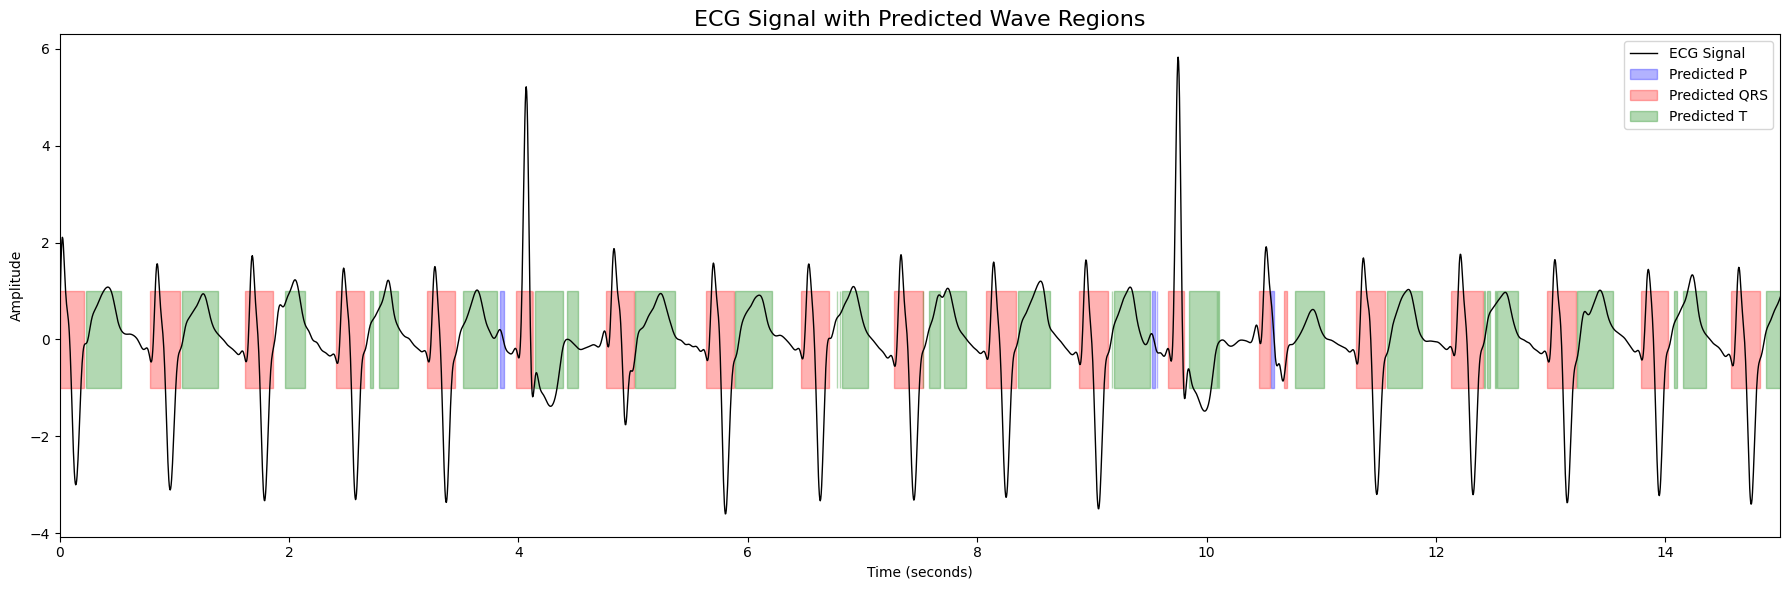

In [31]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/104')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(342, 358), (530, 551), (715, 737), (894, 922), (1083, 1084), (1090, 1108), (1272, 1294), (1458, 1462), (1465, 1485), (1643, 1668), (1830, 1857), (2019, 2044), (2206, 2232), (2399, 2420), (2580, 2606), (2766, 2793), (2961, 2986), (3149, 3174), (3336, 3362), (3530, 3555), (3718, 3746), (3905, 3911), (3913, 3932), (4093, 4119), (4292, 4312), (4481, 4507), (4666, 4669), (4674, 4693), (4859, 4888), (5054, 5082), (5245, 5246), (5252, 5270), (5434, 5462), (5626, 5653), (5815, 5844)], 'QRS': [(0, 24), (34, 36), (48, 59), (170, 202), (366, 397), (557, 587), (744, 773), (928, 957), (960, 960), (1115, 1144), (1302, 1331), (1490, 1519), (1677, 1705), (1864, 1893), (2051, 2080), (2238, 2266), (2427, 2456), (2613, 2642), (2800, 2830), (2993, 3021), (3180, 3210), (3369, 3399), (3563, 3592), (3751, 3779), (3939, 3968), (4126, 4156), (4318, 4346), (4513, 4541), (4701, 4730), (4896, 4926), (5087, 5116), (5278, 5303), (5305, 5305), (5469, 5498), (5659, 5688), (5850, 5879)], 'T': [(37, 47), (

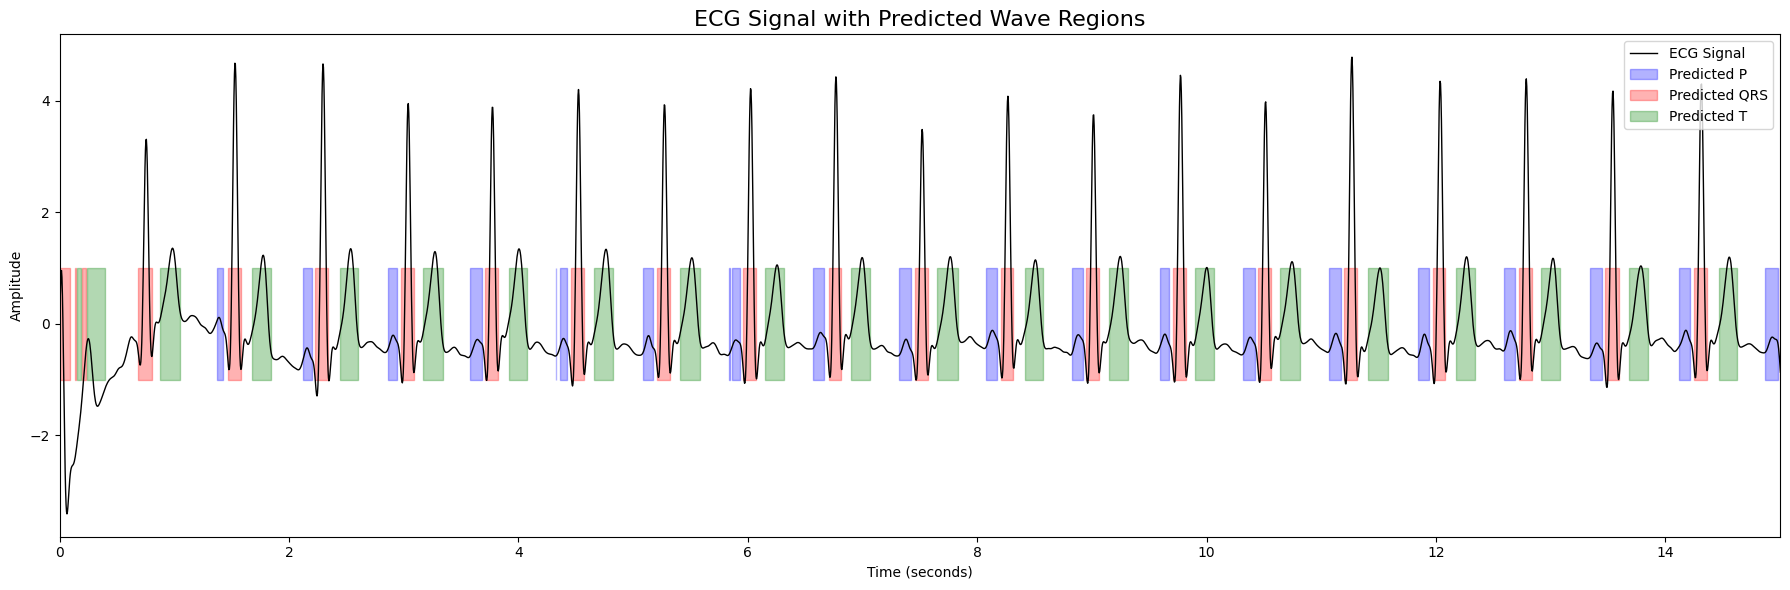

In [32]:


#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/116')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(49, 74), (106, 130), (272, 295), (447, 461), (602, 626), (720, 720), (723, 724), (767, 795), (940, 948), (954, 965), (1106, 1131), (1212, 1237), (1260, 1261), (1263, 1292), (1436, 1459), (1607, 1630), (1715, 1735), (1773, 1801), (1945, 1966), (2109, 2112), (2115, 2132), (2275, 2299), (2440, 2465), (2613, 2632), (2783, 2806), (2891, 2912), (2936, 2942), (2945, 2973), (3116, 3137), (3282, 3306), (3396, 3416), (3457, 3483), (3626, 3652), (3796, 3819), (3961, 3984), (4080, 4081), (4083, 4084), (4133, 4154), (4297, 4317), (4467, 4492), (4579, 4607), (4635, 4659), (4802, 4826), (4966, 4989), (5073, 5098), (5134, 5157), (5301, 5324), (5466, 5490), (5627, 5651), (5792, 5817), (5960, 5981)], 'QRS': [(138, 167), (302, 331), (468, 493), (634, 663), (804, 827), (972, 999), (1139, 1168), (1299, 1328), (1468, 1493), (1640, 1668), (1809, 1838), (1974, 2002), (2140, 2165), (2307, 2335), (2475, 2498), (2645, 2668), (2814, 2843), (2981, 3010), (3146, 3173), (3315, 3344), (3491, 3520), (3661

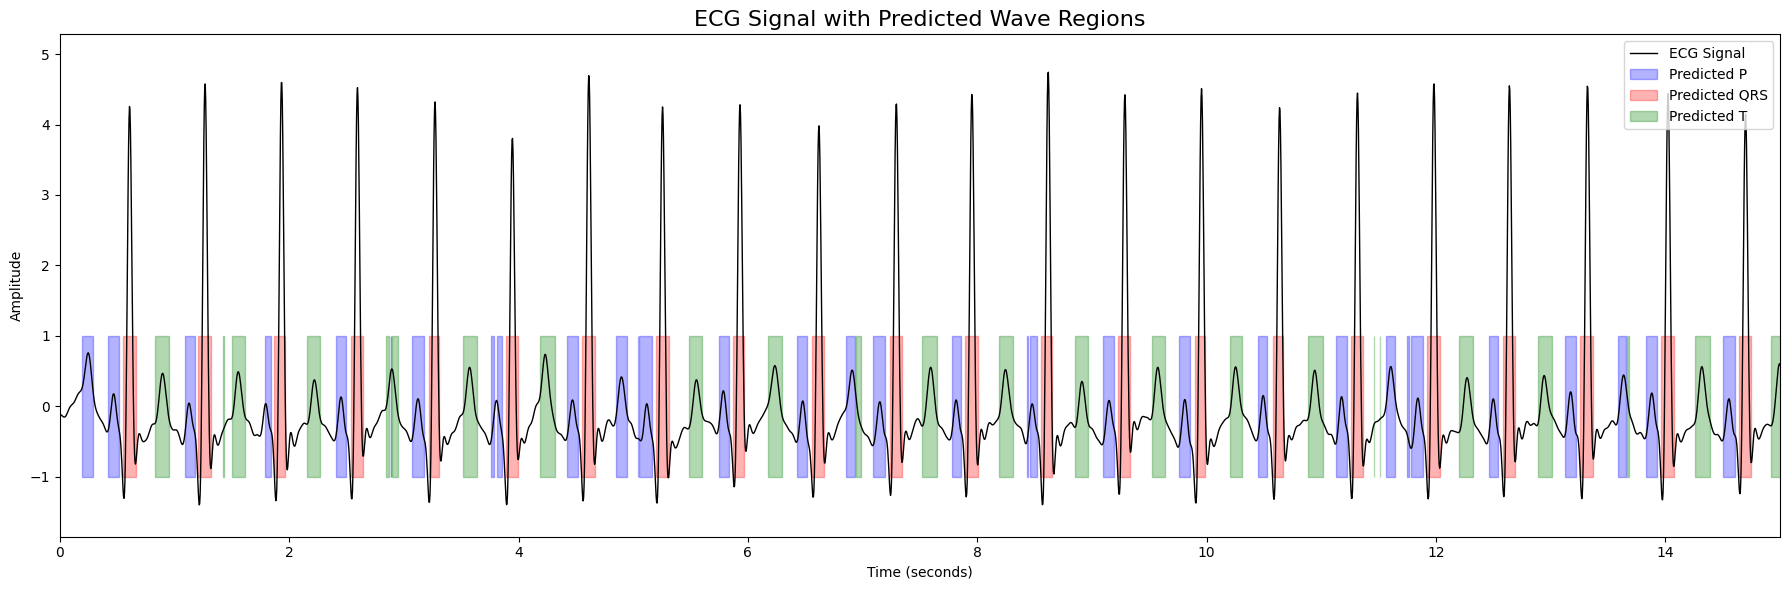

In [33]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/205')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(1, 3), (81, 104), (208, 209), (215, 218), (278, 297), (472, 492), (594, 596), (599, 599), (602, 605), (607, 609), (666, 685), (850, 873), (1039, 1057), (1226, 1252), (1417, 1439), (1602, 1621), (1782, 1803), (1966, 1984), (2148, 2169), (2331, 2356), (2518, 2540), (2699, 2721), (2869, 2869), (2876, 2879), (2881, 2905), (3020, 3020), (3078, 3098), (3200, 3201), (3207, 3210), (3264, 3283), (3440, 3461), (3626, 3645), (3808, 3830), (4000, 4019), (4185, 4206), (4368, 4390), (4497, 4498), (4555, 4575), (4749, 4769), (4933, 4953), (5111, 5132), (5292, 5316), (5427, 5427), (5473, 5501), (5666, 5690)], 'QRS': [(113, 150), (303, 342), (498, 532), (534, 535), (692, 722), (880, 915), (1064, 1102), (1258, 1293), (1447, 1480), (1627, 1659), (1662, 1662), (1810, 1846), (1992, 2027), (2176, 2212), (2364, 2396), (2548, 2584), (2727, 2763), (2914, 2950), (3106, 3143), (3290, 3326), (3469, 3505), (3652, 3689), (3838, 3874), (4027, 4064), (4213, 4249), (4398, 4432), (4584, 4622), (4777, 4810)

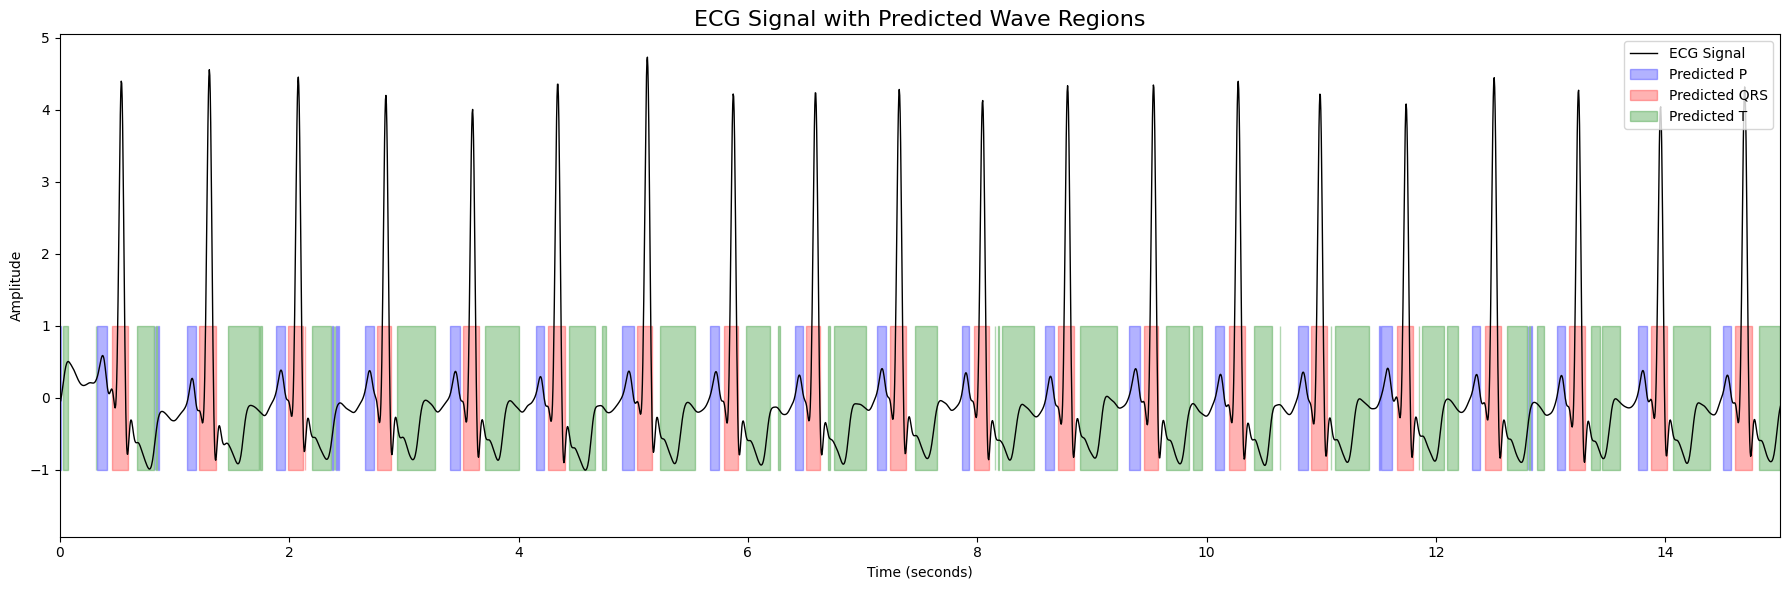

In [34]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/223')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))